In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.base import clone
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix, DecisionBoundariesVisualizer

from BEKML import BEMKL, poly_kernel, gauss_kernel, scoring


def plot_decision_boundaries(model, X, y, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).gca()
    dv = DecisionBoundariesVisualizer(model, classes=[-1, 1],
                                      ax=ax, step_size=0.025, show_scatter=False)
    markers = next(dv.markers), next(dv.markers)
    ax.scatter(*X[y==-1].T, color=dv.colors[0], edgecolors='black', marker=markers[0], s=30)
    ax.scatter(*X[y==1].T, color=dv.colors[1], edgecolors='black', marker=markers[1], s=30)
    dv.fit_draw_poof(X, y)

    
def evaluate_model(model, X, y):
    X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.2, stratify=y)

    model.fit(X_train, y_train)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    cr = ClassificationReport(model, classes=[-1, 1], ax=ax)
    cr.fit(X_train, y_train)
    cr.score(X_test, y_test)
    cr.poof()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    cm = ConfusionMatrix(model, classes=[-1, 1], ax=ax)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.poof()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    rocauc = ROCAUC(model, classes=[-1, 1], ax=ax)
    rocauc.fit(X_train, y_train)
    rocauc.score(X_test, y_test)
    rocauc.poof()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    plot_decision_boundaries(model, X, y, ax=ax)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    model.plot_e(rug=True, kde=True, norm_hist=True, ax=ax,
                 rug_kws={'color': 'r', 'linewidth': 2,
                          'alpha':1})
    
    model_cv = clone(model)
    scoring.iteration = 0
    folds = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)
    return cross_validate(model_cv, X, y, cv=folds, scoring=scoring)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)
N = 1000
D = 2

Populating the interactive namespace from numpy and matplotlib


,x1,x2,y
0,3.525148,-2.493338,1
1,-2.322570,3.561591,1
2,1.142040,2.511545,-1
3,-3.744445,2.353660,1
4,-3.351046,1.097228,1


,x1,x2,y
count,1000.000000,1000.000000,1000.0000
mean,0.006489,0.009602,0.0000
std,3.130019,3.126632,1.0005
min,-5.337235,-6.127693,-1.0000
25%,-2.905133,-2.925322,-1.0000
50%,0.234160,-0.051972,0.0000
75%,2.934014,2.937361,1.0000
max,6.057437,6.035942,1.0000


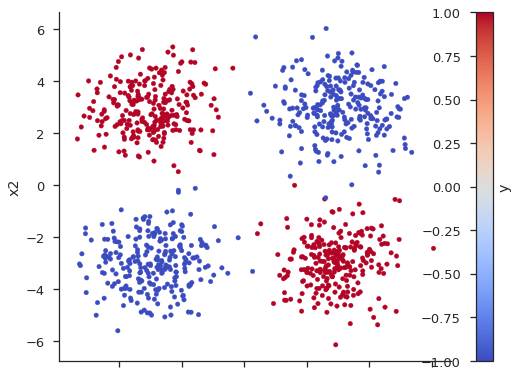

In [3]:
corner = 3
centers = [[-corner, -corner], [-corner, corner],
           [corner, -corner], [corner, corner]]
X, y = make_blobs(n_samples=N, centers=centers)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[(y==0) | (y==3)] = -1
y[y==2] = 1
data['y'] = y
display(data.head())
display(data.describe())
data.plot.scatter('x1', 'x2', c='y', cmap='coolwarm')
sns.despine()
plt.tight_layout()

In [4]:
kernels = [lambda A, B: gauss_kernel(A, B, 2**i) for i in range(-3, 7)]
kernels += [lambda A, B: poly_kernel(A, B, 0, i) for i in range(1, 4)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i) for i in range(-3, 7) for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 0, i) for i in range(1, 4) for j in range(D)]
len(kernels)

39

# Sparse Model

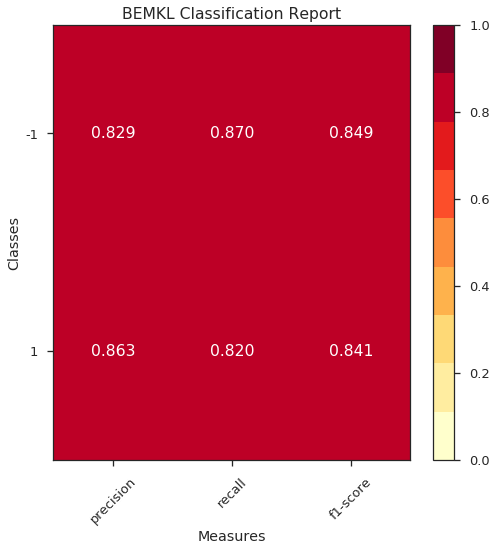

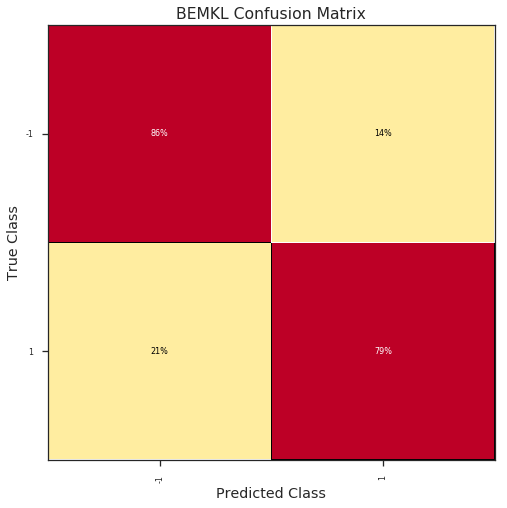

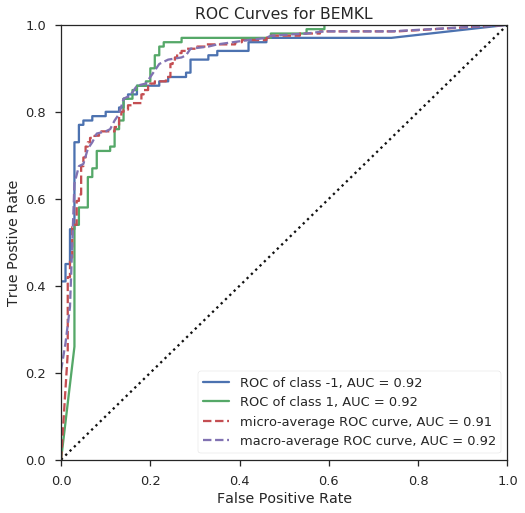

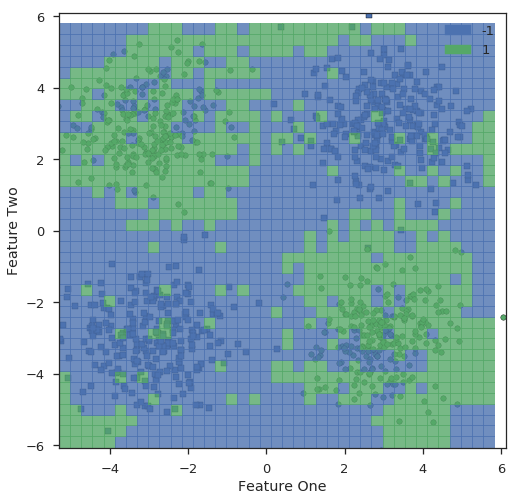

0 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1320. Median e: 0.1160. Std e: 0.0999. 
1 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1373. Median e: 0.1168. Std e: 0.1073. 
2 - Non-0: 33. Total: 39. Ratio: 0.8461538461538461. Mean e: 0.1397. Median e: 0.1042. Std e: 0.1020. 
3 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1341. Median e: 0.0999. Std e: 0.1180. 
4 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1313. Median e: 0.1015. Std e: 0.1121. 
5 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1343. Median e: 0.1058. Std e: 0.1126. 


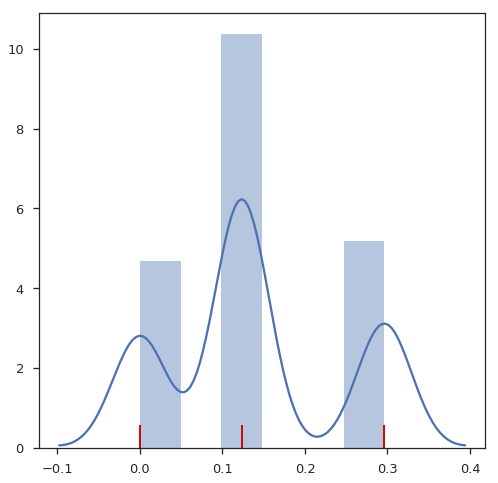

In [5]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9,
                     null_threshold=1e-3)
evaluate_model(sparse_model, X, y)

# Non-Sparse Model

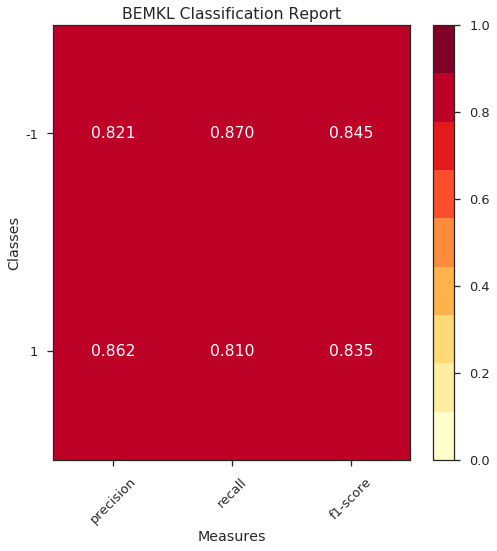

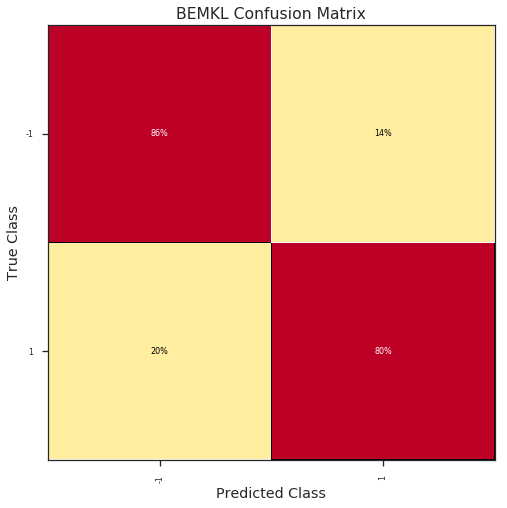

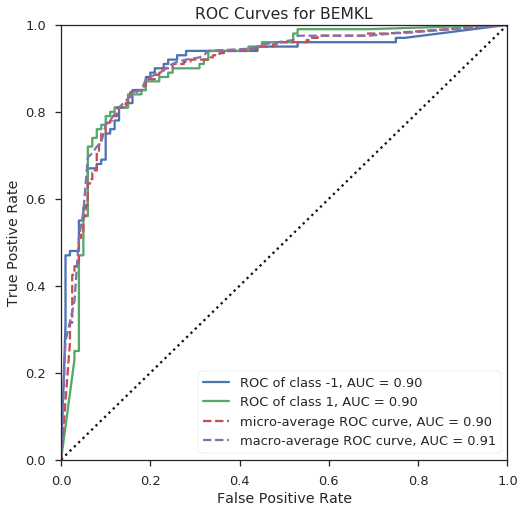

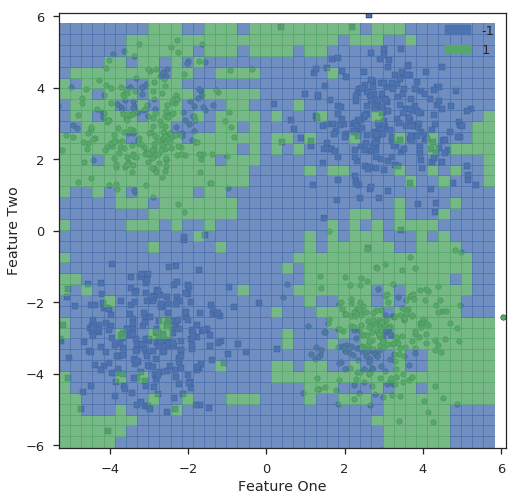

0 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1589. Median e: 0.1305. Std e: 0.0766. 
1 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1653. Median e: 0.1273. Std e: 0.0864. 
2 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1521. Median e: 0.1168. Std e: 0.1027. 
3 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1605. Median e: 0.1028. Std e: 0.1005. 
4 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1840. Median e: 0.1296. Std e: 0.0757. 
5 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1632. Median e: 0.1308. Std e: 0.0923. 


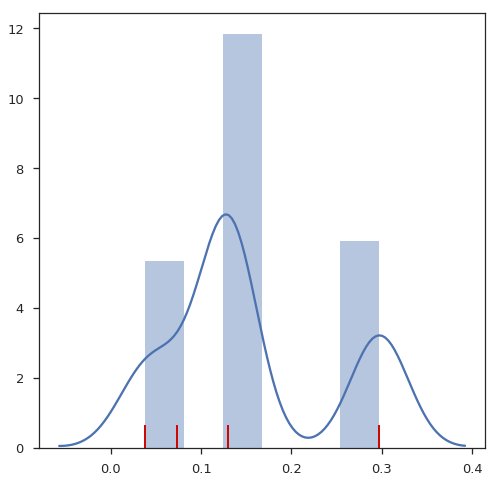

In [6]:
normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1, null_threshold=1e-3)
evaluate_model(normal_model, X, y)